In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../code/')
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow import keras

import utils
from data_loading import ImageSequence

from keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input

In [3]:
tf.get_logger().setLevel('INFO')

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### adversarial loop

In [5]:
EPS = 5 / 255.0
LR = 0.05
optimizer = Adam(learning_rate=LR)
lossfn = CategoricalCrossentropy()

def clip_eps(tensor, eps):
    # clip the values of the tensor to a given range and return it
    return tf.clip_by_value(tensor, clip_value_min=-eps,
        clip_value_max=eps)

def generate_adversaries(model, baseImage, delta, classIdx, steps=50, verbose=False):
    ty = np.zeros(1001)
    ty[classIdx] = 1
    ty = np.expand_dims(ty, axis=0)
    for step in range(0, steps):
        with tf.GradientTape() as tape:
            tape.watch(delta)
            adversary = baseImage + preprocess_input(delta)
            predictions = model(adversary, training=False)
            loss = lossfn(tf.convert_to_tensor(ty), predictions)                        
            if verbose and step % 10 == 0:
                print("step: {}, loss: {}...".format(step,
                    loss.numpy()))
        # calculate the gradients of loss with respect to the perturbation vector
        gradients = tape.gradient(loss, delta)
        # update the weights, clip the perturbation vector, and
        # update its value
        optimizer.apply_gradients([(gradients, delta)])
        delta.assign_add(clip_eps(delta, eps=EPS))
    return delta            

## Load samples

In [6]:
dataset_path = '/data/datasets/imagenet2012/'

In [7]:
train_generator = ImageSequence(dataset_path, 80, target_split='train', square_ims='center_pad', augment=True)

  1%|          | 12/1001 [00:00<00:08, 119.01it/s]

generating splits


100%|██████████| 1001/1001 [00:09<00:00, 105.28it/s]


In [8]:
new_model = keras.models.load_model('./resnet_1001_10_iters.hdf5')

In [9]:
s = train_generator.get_random_sample('test', cat=1000)
proc_s = train_generator.load_im_and_proc(s[1])
s
s[1] = '/home/ivan/Dropbox/scratch/brad_targets/aa.jpeg'

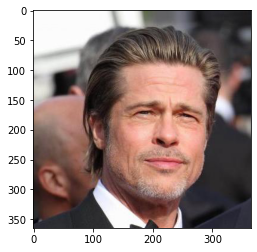

In [10]:
plt.figure()
plt.imshow(plt.imread(s[1]))

In [11]:
pp = new_model.predict(proc_s)
np.argmax(pp[0]), np.max(pp[0]), pp[0][1000]

(1000, 0.995889, 0.995889)

In [12]:
class_desc_mapper = train_generator.generate_classes_and_desc()

In [13]:
# from PIL import Image

In [14]:
# i_path = '/home/ivan/scratch/marmot.jpg'
# i_path = s[1]
# im_pil_raw_squared = utils.center_crop_square(i_path, desired_size=224)
# im_ar =  np.asarray(im_pil_raw_squared).copy()
# im_ar_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))[0]
im_ar = plt.imread(s[1])
im_ar_proc = train_generator.load_im_and_proc(s[1])
im_ar_proc_single = im_ar_proc[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


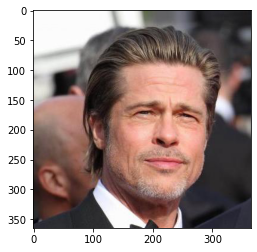

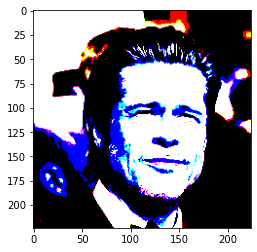

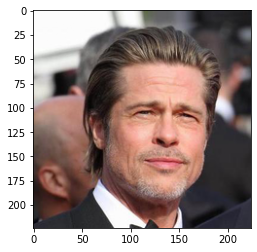

In [15]:
plt.figure()
plt.imshow(im_ar)
plt.figure()
plt.imshow(im_ar_proc_single)
plt.figure()
plt.imshow(utils.depreprocess(im_ar_proc_single)/255)

https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

In [16]:
# # ii = image.load_img(i_path, target_size=(224, 224))
# # ii = image.load_img(i_path, target_size=(224, 224))
# im_ar =  image.img_to_array(im_pil_raw_squared).copy()
# im_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))

baseImage = tf.constant(im_ar_proc, dtype=tf.float32)
delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
deltaUpdated = generate_adversaries(new_model, baseImage, delta, 245, steps=200, verbose=True)

adverImage = (baseImage + deltaUpdated).numpy().squeeze()
adverImage = np.clip(adverImage, 0, 255).astype("uint8")

step: 0, loss: 20.228601455688477...
step: 10, loss: 4.569601058959961...
step: 20, loss: 0.07405577600002289...
step: 30, loss: 0.008246419951319695...
step: 40, loss: 0.005725413095206022...
step: 50, loss: 0.0060854386538267136...
step: 60, loss: 0.006579166743904352...
step: 70, loss: 0.006326173432171345...
step: 80, loss: 0.0059351869858801365...
step: 90, loss: 0.0051854876801371574...
step: 100, loss: 0.004515213891863823...
step: 110, loss: 0.004102980252355337...
step: 120, loss: 0.0036532822996377945...
step: 130, loss: 0.0034143980592489243...
step: 140, loss: 0.0036676537711173296...
step: 150, loss: 0.00392618915066123...
step: 160, loss: 0.003783213207498193...
step: 170, loss: 0.0035497054923325777...
step: 180, loss: 0.00343542592599988...
step: 190, loss: 0.003382320748642087...


W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.300595e-05
suit 834 2.6937158e-05


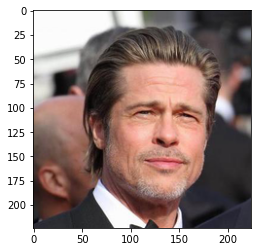

______________
ballpoint 418 0.24659751
wallet 893 0.17956619
American_coot 137 0.16083784


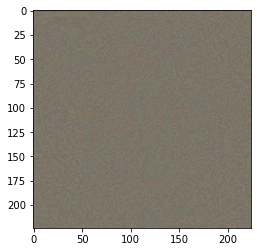

______________
W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.300595e-05
suit 834 2.6937158e-05


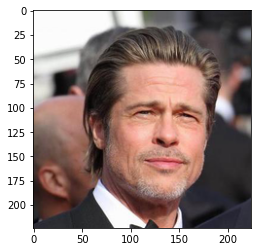

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.92955846
W Bradley Pitt, aka Brad 1000 0.032627255
French_bulldog 245 0.008656731


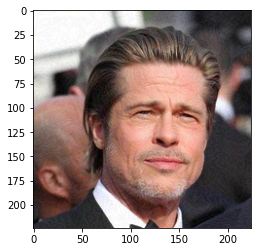

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.5508727
beagle 162 0.16982731
vizsla 211 0.03983596


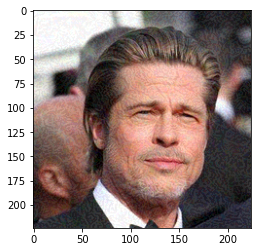

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
bow_tie 457 0.22320808
jigsaw_puzzle 611 0.19287302
Chihuahua 151 0.12554796


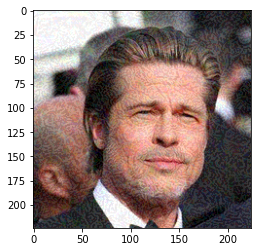

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.40146193
eel 390 0.25959417
chain_mail 490 0.09270956


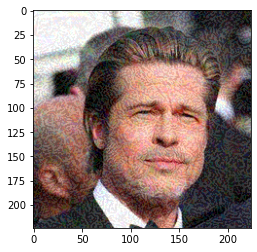

______________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


eel 390 0.5720717
jigsaw_puzzle 611 0.29272556
chain_mail 490 0.06656832


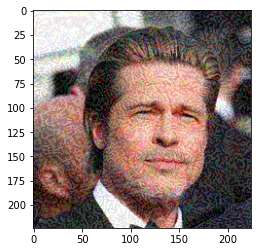

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
eel 390 0.41847277
jigsaw_puzzle 611 0.2974942
loupe 633 0.18466058


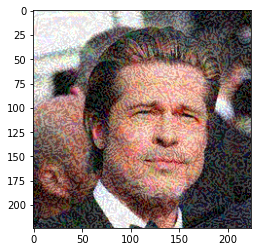

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.49692908
loupe 633 0.30154994
eel 390 0.14802201


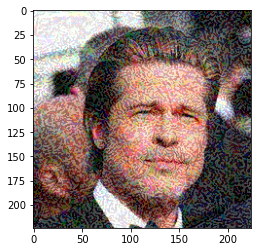

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.504516
loupe 633 0.36291134
eel 390 0.11378723


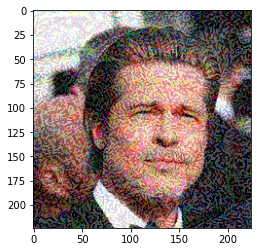

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.7381111
loupe 633 0.1389581
eel 390 0.11726916


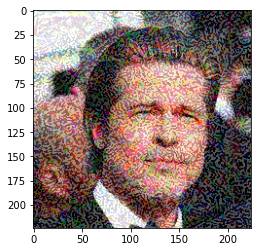

______________


In [18]:
ims_test = [baseImage, deltaUpdated]
for i in range(10):
    ims_test.append(baseImage + i* deltaUpdated)

ims_test = np.concatenate(ims_test,axis=0)
preds_all = new_model.predict(ims_test)

for ii, p in zip(ims_test, preds_all):
    top_args = p.argsort()[-3:][::-1]
    plt.figure()
    plt.imshow(np.round(utils.depreprocess(ii)).astype('int32'))
    for ta in top_args:
        print(class_desc_mapper[ta], ta, p[ta])
    plt.show()
    print('______________')

### Brute force loop

  0%|          | 0/4 [00:00<?, ?it/s]

W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.3004084e-05
suit 834 2.6936721e-05


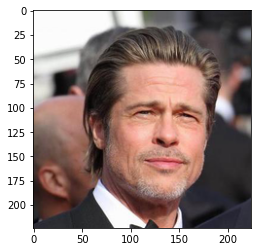

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.83610314
bow_tie 457 0.085651994
military_uniform 652 0.04916817


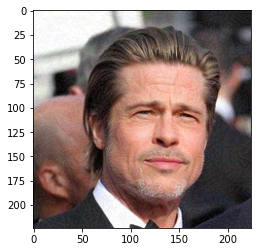

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.97454756
bow_tie 457 0.011385543
military_uniform 652 0.0041200253


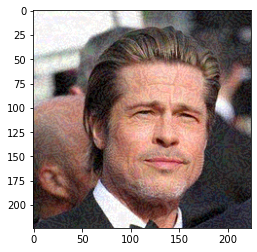

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.60546577
jigsaw_puzzle 611 0.20117365
chain_mail 490 0.055740014


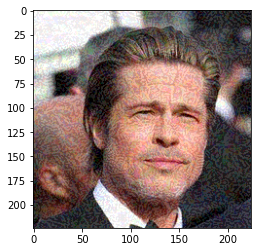

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.7963661
loupe 633 0.15942791
chain_mail 490 0.0160685


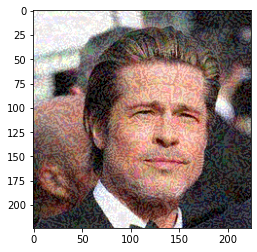

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
loupe 633 0.53064626
jigsaw_puzzle 611 0.45105162
chain_mail 490 0.009457725


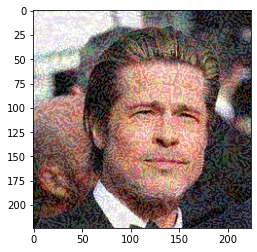

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.4968742
loupe 633 0.49485964
chain_mail 490 0.0046262336


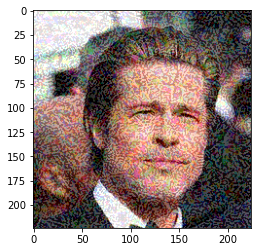

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.5919851
loupe 633 0.39869732
chain_mail 490 0.0051154066


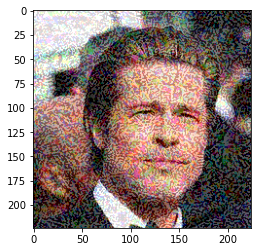

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.79263705
loupe 633 0.17753585
chain_mail 490 0.012436618


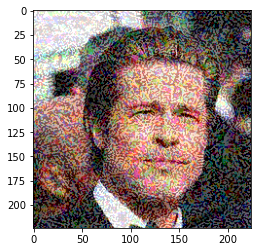

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.87036335
eel 390 0.102445506
chain_mail 490 0.006556721


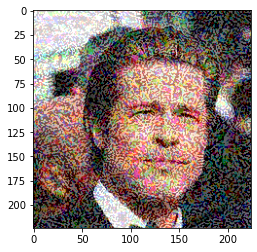

 25%|██▌       | 1/4 [01:21<04:04, 81.52s/it]

______________
W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.3004084e-05
suit 834 2.6936721e-05


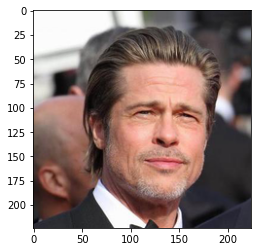

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.66395944
ram 348 0.12893409
armadillo 363 0.020966051


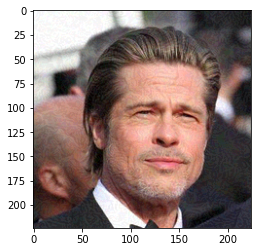

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.23288257
chain_mail 490 0.18737176
jigsaw_puzzle 611 0.14947586


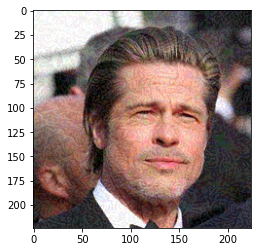

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
loupe 633 0.4145953
chain_mail 490 0.2664725
jigsaw_puzzle 611 0.25772482


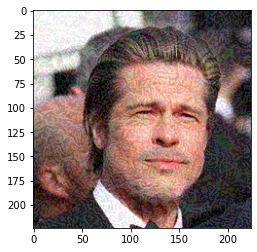

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
chain_mail 490 0.53473926
loupe 633 0.32166693
jigsaw_puzzle 611 0.1385976


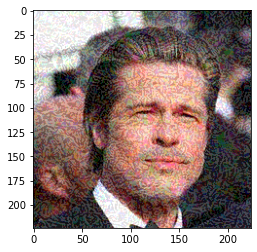

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
loupe 633 0.46995372
chain_mail 490 0.4110957
jigsaw_puzzle 611 0.11673822


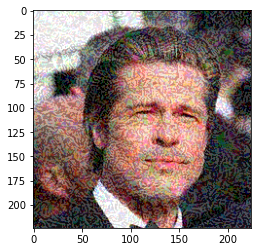

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
loupe 633 0.5890734
jigsaw_puzzle 611 0.36154547
chain_mail 490 0.042573802


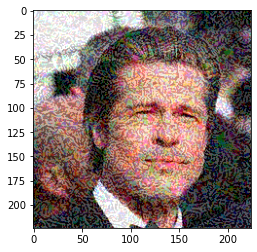

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.88150656
loupe 633 0.080603845
eel 390 0.024842786


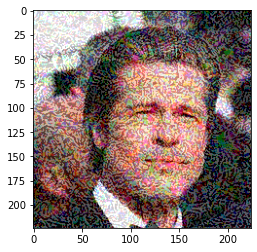

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.9125299
eel 390 0.045997374
mushroom 947 0.02132835


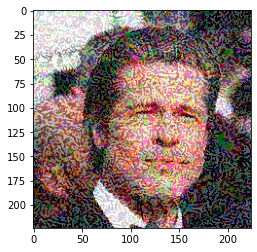

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.87998134
miniature_pinscher 237 0.06443926
eel 390 0.033942208


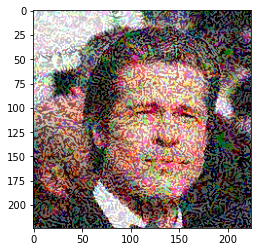

 50%|█████     | 2/4 [02:19<02:14, 67.43s/it]

______________
W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.3004084e-05
suit 834 2.6936721e-05


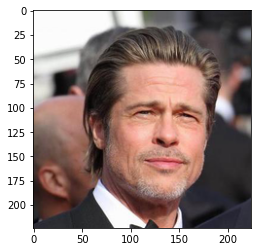

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.91902506
bow_tie 457 0.05609137
seat_belt 785 0.017247355


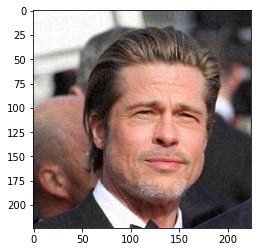

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.9883058
jigsaw_puzzle 611 0.007519343
bow_tie 457 0.003820967


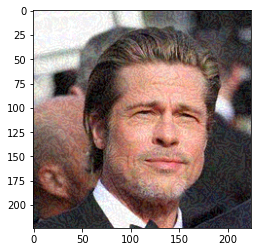

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.9276509
jigsaw_puzzle 611 0.04915376
bow_tie 457 0.020257294


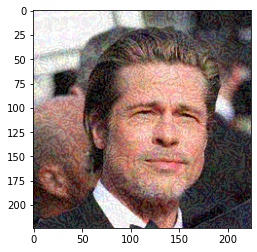

______________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


jigsaw_puzzle 611 0.45936376
W Bradley Pitt, aka Brad 1000 0.33907878
chain_mail 490 0.12690839


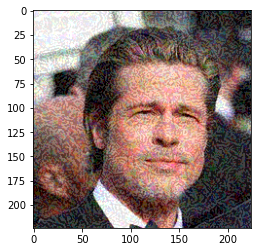

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.57185674
chain_mail 490 0.36351436
bow_tie 457 0.037031777


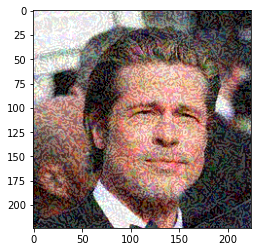

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.8918179
chain_mail 490 0.10477517
bow_tie 457 0.0014254232


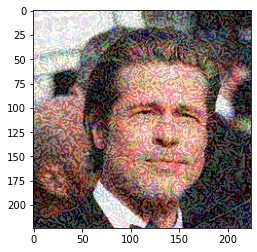

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.9891689
chain_mail 490 0.009679841
loupe 633 0.00052282587


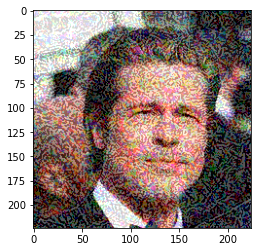

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.99796754
eel 390 0.0014910034
chain_mail 490 0.00022882034


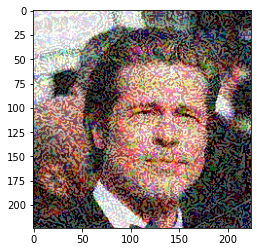

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.9862027
eel 390 0.012821345
miniature_pinscher 237 0.00044225436


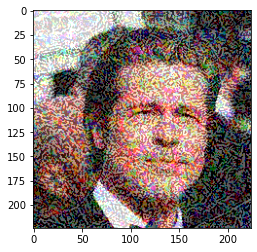

 75%|███████▌  | 3/4 [03:16<01:02, 62.84s/it]

______________
W Bradley Pitt, aka Brad 1000 0.9998629
bow_tie 457 9.3004084e-05
suit 834 2.6936721e-05


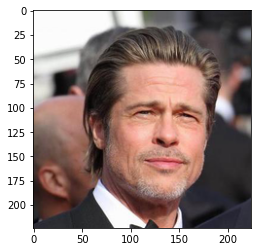

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.74101895
bow_tie 457 0.18268256
sunscreen 838 0.03447871


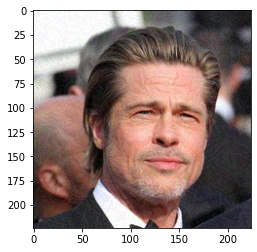

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
W Bradley Pitt, aka Brad 1000 0.8417223
West_Highland_white_terrier 203 0.050233524
jigsaw_puzzle 611 0.037802283


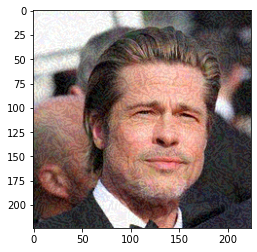

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.7347256
bonnet 452 0.14059065
miniature_pinscher 237 0.04173932


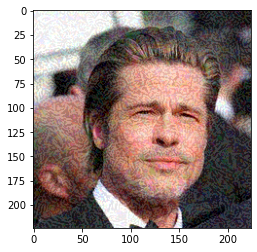

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.94008756
bonnet 452 0.03264383
miniature_pinscher 237 0.008153014


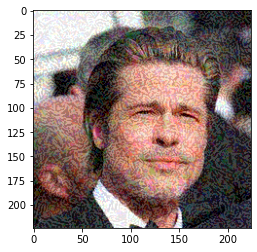

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.86048436
loupe 633 0.058004007
chain_mail 490 0.031101717


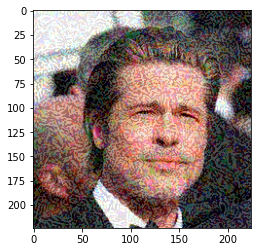

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.8285649
chain_mail 490 0.06584732
mask 643 0.042651977


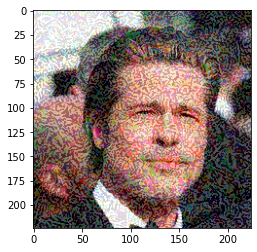

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.97707295
eel 390 0.008138338
mask 643 0.006586002


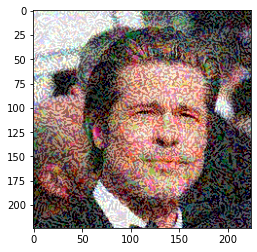

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.99251914
eel 390 0.0044466117
Rhodesian_ridgeback 159 0.0009094452


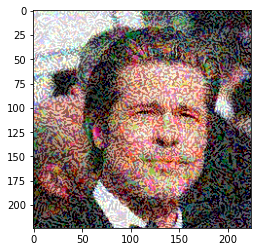

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


______________
jigsaw_puzzle 611 0.992365
coral_reef 973 0.0036446918
eel 390 0.0024085345


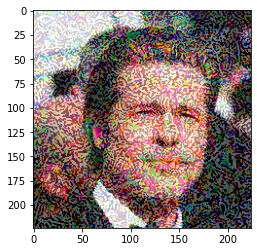

100%|██████████| 4/4 [04:16<00:00, 64.07s/it]

______________


In [19]:
# im_ar =  image.img_to_array(im_pil_raw_squared).copy()
# # im_proc = preprocess_input(np.expand_dims(im_ar.copy(), axis=0))
# im_ar_proc

noise_strengs = np.arange(10) / 2
# iterate over different noise categories
outputs = []
for noise_cat in tqdm(np.random.choice(np.arange(1000), 4, replace=True)):

    baseImage = tf.constant(im_ar_proc, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(baseImage), trainable=True)
    deltaUpdated = generate_adversaries(new_model, baseImage, delta, noise_cat, steps=500, verbose=False)

#     adverImage = (baseImage + deltaUpdated).numpy().squeeze()
#     adverImage = np.clip(adverImage, 0, 255).astype("uint8")

    ims_test = np.concatenate([baseImage + ns * deltaUpdated for ns in noise_strengs], axis=0)
    preds_all = new_model.predict(ims_test)
#     preds_decoded = utils.decode_predictions(preds_all, top=3)
    for ii, p in zip(ims_test, preds_all):
        top_args = p.argsort()[-3:][::-1]
        top_desc = [class_desc_mapper[ta] for ta in top_args]
        plt.figure()
        plt.imshow(np.round(utils.depreprocess(ii)).astype('int32'))
        for ta in top_args:
            print(class_desc_mapper[ta], ta, p[ta])
        plt.show()
        print('______________')
    
    for ns, pred in zip(noise_strengs, top_desc):
        sample = [s[1], noise_cat, ns, pred]
        outputs.append(sample)
        
            